## plot strike, bid/ask, call, put amount v.s. PERP and underlying
   * using different marker size to represent amount of bid/ask
   * using diffrernt color to mark bid and ask 
   * left y-axis for strike
   * right y-axis for underlying price
   * hover mouse to show option price
   * 5 expire x put/call x bid/ask = 20 plots => 20 html files

In [78]:
from cdcqr.common.config import LOCAL_DATA_DIR
from cdcqr.data.dataloader import data_loader
from cdcqr.data.deribit.data_utils import DeribitUtils
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px
import os
from cdcqr.common.config import LOCAL_FIGURE_DIR
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### setup

In [30]:
date = datetime(2021,10,29).date()
exchange = 'deribit'
maturity_date = datetime(2022,6,24).date()
maturity_date = datetime(2021,12,31).date()

freq = '1Min'
coin = 'BTC'

### load - option quote data

In [31]:
symbol = 'OPTIONS'
data_type = 'quotes'
date_ = date.strftime('%Y-%m-%d')
opt_quote = data_loader(exchange, date_, data_type, symbol)
display(opt_quote.head(1))

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount
0,deribit,ETH-30SEP22-50000-C,1635465597886000,1635465600307756,1.0,0.049,0.047,67.0


### load - option chain data

In [32]:
start_date = date
end_date = date
file_name = 'optchain_{}_{}_{}_{}.pkl'.format(start_date.strftime('%Y%m%d'), end_date.strftime('%Y%m%d'), maturity_date.strftime('%Y%m%d'), freq)
optchain = pd.read_pickle(os.path.join(LOCAL_DATA_DIR, file_name))
display(optchain.head(1))

,symbol,tm,aiv,ap,av,biv,bp,bv,delta,exch,...,markiv,oint,rho,strike,theta,ty,underly,s,vega,tau
tm,,,,,,,,,,,,,,,,,,,,,
2021-10-29 00:01:00,BTC-31DEC21-64000-P,2021-10-29,0.9073,0.167,7.2,0.8891,0.164,8.3,-0.45591,deribit,...,0.8987,282.6,-67.06864,64000.0,-72.87977,-1,BTC-31DEC21,62194.87,102.72333,0.173515


### load - PERP data

In [33]:
symbol = '{}-PERPETUAL'.format(coin)
data_type = 'quotes'
PERP_quote = data_loader(exchange, date.strftime('%Y-%m-%d'), data_type, symbol)
display(PERP_quote.head(1))

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount
0,deribit,BTC-PERPETUAL,1635465600154000,1635465600184939,7120,60667.0,60666.5,27810


### data processing - all

In [34]:
uni_index = pd.date_range(start=date, end=date+timedelta(days=1), freq='1Min')[1:]

#### data processing - PERP quote

In [35]:
PERP_quote['dt'] = pd.to_datetime(PERP_quote['timestamp'], unit='us')
PERP_quote['PERP_mid_price'] = (PERP_quote['ask_price']+PERP_quote['bid_price'])/2

In [36]:
PERP_quote_1 = PERP_quote.set_index('dt')['PERP_mid_price']
PERP_quote_2 = PERP_quote_1[~PERP_quote_1.index.duplicated(keep='last')]
PERP_quote_3 = PERP_quote_2.reindex(uni_index, method='ffill')

In [37]:
PERP_quote_3

2021-10-29 00:01:00    60664.75
2021-10-29 00:02:00    60796.25
2021-10-29 00:03:00    60771.50
2021-10-29 00:04:00    60525.25
2021-10-29 00:05:00    60632.25
                         ...   
2021-10-29 23:56:00    62291.75
2021-10-29 23:57:00    62310.75
2021-10-29 23:58:00    62329.25
2021-10-29 23:59:00    62317.25
2021-10-30 00:00:00    62337.25
Freq: T, Name: PERP_mid_price, Length: 1440, dtype: float64

#### data processing - opt chain

In [38]:
optchain['mid_vol'] = 0.5*(optchain['aiv'] + optchain['biv'])

In [39]:
optchain_reduced = optchain[['symbol','strike','underly','s','aiv','biv']]
optchain_reduced = optchain_reduced[optchain_reduced['symbol'].str.contains('{}-'.format(coin))]
optchain_reduced = optchain_reduced.pipe(DeribitUtils.parse_optSymbol_col)

In [40]:
# 1. get underlying price
optchain_reduced_1 = optchain_reduced['s']
optchain_reduced_2 = optchain_reduced_1[~optchain_reduced_1.index.duplicated(keep='last')]
optchain_reduced_2 = optchain_reduced_2.sort_index()
optchain_reduced_3 = optchain_reduced_2.reindex(uni_index, method='ffill').to_frame()

In [41]:
# 2. get ask iv per strike, per type
optchain_reduced_1a = optchain_reduced[['aiv', 'biv', 'strike', 'type']]

In [42]:
optchain_reduced_1a = optchain_reduced_1a.reset_index().rename(columns={'tm':'index'})

In [43]:
# remove duplicates in opt chain
optchain_reduced_1a = optchain_reduced_1a[~optchain_reduced_1a.set_index(['type','strike','index']).index.duplicated(keep='last')]

In [44]:
optchain_reduced_3.columns = ['underlying_price']
df_underlying = optchain_reduced_3.join(PERP_quote_3).reset_index()

In [45]:
display(df_underlying.head(2))

,index,underlying_price,PERP_mid_price
0,2021-10-29 00:01:00,62188.03,60664.75
1,2021-10-29 00:02:00,62324.57,60796.25


In [46]:
optchain_reduced_1a.head(2)

,index,aiv,biv,strike,type
84699,2021-10-29 00:01:00,0.9073,0.8891,64000.0,P
84700,2021-10-29 00:02:00,0.9031,0.8880,64000.0,P


#### data processing - option quote

In [47]:
opt_quote_parsed = opt_quote.pipe(DeribitUtils.parse_optSymbol_col)

'parse_optSymbol_col'  26.72 sec


In [48]:
opt_quote_parsed['timestamp_dt'] = pd.to_datetime(opt_quote_parsed['timestamp'], unit='us')

In [49]:
# only look at BTC
opt_quote_parsed = opt_quote_parsed.query('instrument=="BTC"')

In [50]:
opt_quote_parsed

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,strike,type,timestamp_dt
173,deribit,BTC-5NOV21-78000-C,1635465595983000,1635465600365586,77.3,0.0025,0.0015,17.9,BTC,2021-11-05,78000.0,C,2021-10-28 23:59:55.983
174,deribit,BTC-5NOV21-75000-C,1635465599207000,1635465600365644,4.5,0.0035,0.0025,48.4,BTC,2021-11-05,75000.0,C,2021-10-28 23:59:59.207
175,deribit,BTC-5NOV21-74000-P,1635465599185000,1635465600365698,5.0,0.6190,NaN,NaN,BTC,2021-11-05,74000.0,P,2021-10-28 23:59:59.185
176,deribit,BTC-5NOV21-74000-C,1635465590639000,1635465600365838,4.0,0.0040,0.0030,75.8,BTC,2021-11-05,74000.0,C,2021-10-28 23:59:50.639
177,deribit,BTC-5NOV21-70000-C,1635465595985000,1635465600365840,33.2,0.0085,0.0075,40.4,BTC,2021-11-05,70000.0,C,2021-10-28 23:59:55.985
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8049083,deribit,BTC-31DEC21-50000-P,1635551999709000,1635551999714540,26.7,0.0495,0.0475,4.4,BTC,2021-12-31,50000.0,P,2021-10-29 23:59:59.709
8049084,deribit,BTC-5NOV21-58000-P,1635551999711000,1635551999714552,14.4,0.0130,0.0125,22.0,BTC,2021-11-05,58000.0,P,2021-10-29 23:59:59.711
8049100,deribit,BTC-26NOV21-66000-P,1635551999788000,1635551999797023,8.5,0.1180,0.1150,5.1,BTC,2021-11-26,66000.0,P,2021-10-29 23:59:59.788
8049101,deribit,BTC-12NOV21-62000-C,1635551999787000,1635551999797925,7.5,0.0680,0.0660,9.0,BTC,2021-11-12,62000.0,C,2021-10-29 23:59:59.787


In [51]:
# select relevant expire dates
selected_expr_dates = DeribitUtils.get_important_option_expire_dates(pd.to_datetime(date))
display(maturity_date)
display(selected_expr_dates)

datetime.date(2021, 12, 31)

[datetime.date(2021, 11, 26),
 datetime.date(2021, 12, 31),
 datetime.date(2022, 3, 25),
 datetime.date(2022, 6, 24)]

In [52]:
opt_quote_parsed['exp_date'] = opt_quote_parsed['expire'].dt.date

In [53]:
opt_quote_parsed_expire_i_c = opt_quote_parsed.query('exp_date==@maturity_date & type =="C"')
opt_quote_parsed_expire_i_p = opt_quote_parsed.query('exp_date==@maturity_date & type =="P"')

In [54]:
list(sorted(opt_quote_parsed_expire_i_c['strike'].unique())) == sorted(opt_quote_parsed_expire_i_c['strike'].unique())
strike_list = list(sorted(opt_quote_parsed_expire_i_c['strike'].unique()))
len(strike_list)

39

In [55]:
opt_quote_parsed_expire_i_c_reduced = opt_quote_parsed_expire_i_c.drop(labels=['exchange','symbol','timestamp','local_timestamp','type','expire','t2m'], axis=1, errors='ignore')
opt_quote_parsed_expire_i_p_reduced = opt_quote_parsed_expire_i_p.drop(labels=['exchange','symbol','timestamp','local_timestamp','type','expire','t2m'], axis=1, errors='ignore')

In [56]:
strike2df = {}
for strike in strike_list:
    #print(strike)
    opt_quote_parsed_expire_i_c_reduced_k_1 = opt_quote_parsed_expire_i_c_reduced.query('strike==@strike').set_index('timestamp_dt')
    opt_quote_parsed_expire_i_c_reduced_k_1 = opt_quote_parsed_expire_i_c_reduced_k_1[~opt_quote_parsed_expire_i_c_reduced_k_1.index.duplicated(keep='last')]
    opt_quote_parsed_expire_i_c_reduced_k_1 = opt_quote_parsed_expire_i_c_reduced_k_1.reindex(uni_index, method='ffill')
    strike2df[strike] = opt_quote_parsed_expire_i_c_reduced_k_1
    #display(opt_quote_btc_expire_i_c_reduced_k_1_1min.head(2))
df_combined = pd.concat(strike2df.values()).reset_index()
df_combined['ask_amount'] = df_combined['ask_amount'].fillna(0)
df_combined['bid_amount'] = df_combined['bid_amount'].fillna(0)
df_combined_c = df_combined.copy()

In [57]:
strike2df = {}
for strike in opt_quote_parsed_expire_i_p_reduced['strike'].unique():
    #print(strike)
    opt_quote_parsed_expire_i_p_reduced_k_1 = opt_quote_parsed_expire_i_p_reduced.query('strike==@strike').set_index('timestamp_dt')
    opt_quote_parsed_expire_i_p_reduced_k_1 = opt_quote_parsed_expire_i_p_reduced_k_1[~opt_quote_parsed_expire_i_p_reduced_k_1.index.duplicated(keep='last')]
    opt_quote_parsed_expire_i_p_reduced_k_1_1min = opt_quote_parsed_expire_i_p_reduced_k_1.reindex(uni_index, method='ffill')
    strike2df[strike] = opt_quote_parsed_expire_i_p_reduced_k_1_1min
    #display(opt_quote_btc_expire_i_p_reduced_k_1_1min.head(2))
df_combined = pd.concat(strike2df.values()).reset_index()
df_combined['ask_amount'] = df_combined['ask_amount'].fillna(0)
df_combined['bid_amount'] = df_combined['bid_amount'].fillna(0)
df_combined_p = df_combined.copy()

In [58]:
df_combined_c['type'] = 'C'
df_combined_p['type'] = 'P'
df_combined = df_combined_c.append(df_combined_p)

In [59]:
df_combined['strike_shifted'] = df_combined['strike'] + 100*((df_combined['type']=='C').astype(int)-0.5)*2

In [60]:
df_combined.head()

,index,ask_amount,ask_price,bid_price,bid_amount,instrument,strike,exp_date,type,strike_shifted
0,2021-10-29 00:01:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0
1,2021-10-29 00:02:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0
2,2021-10-29 00:03:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0
3,2021-10-29 00:04:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0
4,2021-10-29 00:05:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0


#### data processing - all

In [61]:
df_combined_ext = pd.merge(left=df_combined, right = optchain_reduced_1a, on=['index','strike','type'], how='left')

In [62]:
df_combined_ext['mvol'] = 0.5*(df_combined_ext['aiv']+df_combined_ext['biv'])

In [63]:
display(df_combined.shape)
display(df_combined_ext.shape)

(105120, 10)

(105120, 13)

In [64]:
df_combined_ext['total_amount'] = df_combined_ext['bid_amount'] + df_combined_ext['ask_amount']

### make plot
   * ask amount with call and put scatter plot
   * bid amount with call and put scatter plot
   * ask+bid amount with call and put scatter plot

In [79]:
from plotly.subplots import make_subplots
subfig = make_subplots(specs=[[{"secondary_y": True}]])

In [80]:
from plotly.subplots import make_subplots
subfig = make_subplots(specs=[[{"secondary_y": True}]])
fig1 = px.scatter(df_combined_ext, x="index", y="strike_shifted", size="ask_amount",  hover_data=['strike','ask_price','ask_amount','type', 'biv'], color="biv", title='',width=1500, height=1200)
fig1b = px.scatter(df_combined_ext, x="index", y="strike_shifted", size="bid_amount",  hover_data=['strike','bid_price','bid_amount','type', 'biv'], color="biv", title='',width=1500, height=1200)
fig1c = px.scatter(df_combined_ext, x="index", y="strike_shifted", size="total_amount", hover_data=['strike','ask_price','ask_amount','bid_price','bid_amount','type', 'aiv','biv','mvol'], color="mvol", title='',width=1500, height=1200)

In [ ]:
fig2 = px.line(df_underlying, x='index', y=['underlying_price', 'PERP_mid_price'], width=1500, height=1200)

In [ ]:
#df_combined_ext_20211029 = df_combined_ext.copy()
#%store df_combined_ext_20211029

In [ ]:
fig3 = go.Figure(data=fig1.data + fig2.data,)
fig3.update_layout(
    autosize=False,
    width=1500,
    height=1200,
    title='BTC ask price and amount v.s. underlying & PERP')
fig3.show()
fig3.write_html(os.path.join(LOCAL_FIGURE_DIR,'option_book',date.strftime('%Y%m'), 
                             "{}_options_{}_{}_ask.html".format(coin, date.strftime('%Y%m%d'), maturity_date.strftime('%Y%m%d'))))

In [ ]:
fig3 = go.Figure(data=fig1b.data + fig2.data,)
fig3.update_layout(
    autosize=False,
    width=1500,
    height=1200,
    title='BTC bid price and amount v.s. underlying & PERP')
fig3.show()
fig3.write_html(os.path.join(LOCAL_FIGURE_DIR,'option_book', date.strftime('%Y%m'),
                              "{}_options_{}_{}_bid.html".format(coin, date.strftime('%Y%m%d'), maturity_date.strftime('%Y%m%d'))))

In [ ]:
fig3 = go.Figure(data=fig1c.data + fig2.data,)
fig3.update_layout(
    autosize=False,
    width=1500,
    height=1200,
    title='BTC price and total amount v.s. underlying & PERP')
#fig.show()
fig3.write_html(os.path.join(LOCAL_FIGURE_DIR, 'option_book', date.strftime('%Y%m'),
                              "{}_options_{}_{}_all_quotes.html".format(coin, date.strftime('%Y%m%d'), maturity_date.strftime('%Y%m%d'))))

### plot for ATM options

In [92]:
display(df_combined_ext.head())

,index,ask_amount,ask_price,bid_price,bid_amount,instrument,strike,exp_date,type,strike_shifted,aiv,biv,mvol,total_amount
0,2021-10-29 00:01:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0,NaN,NaN,NaN,28.0
1,2021-10-29 00:02:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0,NaN,NaN,NaN,28.0
2,2021-10-29 00:03:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0,NaN,NaN,NaN,28.0
3,2021-10-29 00:04:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0,NaN,NaN,NaN,28.0
4,2021-10-29 00:05:00,14.0,0.814,0.802,14.0,BTC,12000.0,2021-12-31,C,12100.0,NaN,NaN,NaN,28.0


In [81]:
df_combined_ext_atm = df_combined_ext.query('strike==70000')
df_combined_ext_atm.head(2)

,index,ask_amount,ask_price,bid_price,bid_amount,instrument,strike,exp_date,type,strike_shifted,aiv,biv,mvol,total_amount
36000,2021-10-29 00:01:00,17.5,0.1060,0.1035,12.3,BTC,70000.0,2021-12-31,C,70100.0,0.9183,0.9032,0.91075,29.8
36001,2021-10-29 00:02:00,6.8,0.1065,0.1045,4.5,BTC,70000.0,2021-12-31,C,70100.0,0.9171,0.9049,0.91100,11.3


In [82]:
df_combined_ext_p = df_combined_ext_atm.query('type=="P"')
df_combined_ext_c = df_combined_ext_atm.query('type=="C"')
df_combined_ext_p['type'] = 'P'
df_combined_ext_c['type'] = 'C'

In [83]:
df_combined_ext_p_a = df_combined_ext_p[['index','ask_price', 'ask_amount', 'type', 'aiv']].rename(columns={'ask_price':'price', 'ask_amount':'amount', 'aiv':'iv'})
df_combined_ext_p_a['side'] = 'ask'
df_combined_ext_p_b = df_combined_ext_p[['index','bid_price', 'bid_amount', 'type', 'biv']].rename(columns={'bid_price':'price', 'bid_amount':'amount', 'biv':'iv'})
df_combined_ext_p_b['side'] = 'bid'

df_combined_ext_c_a = df_combined_ext_c[['index','ask_price', 'ask_amount', 'type', 'aiv']].rename(columns={'ask_price':'price', 'ask_amount':'amount', 'aiv':'iv'})
df_combined_ext_c_a['side'] = 'ask'
df_combined_ext_c_b = df_combined_ext_c[['index','bid_price', 'bid_amount', 'type', 'biv']].rename(columns={'bid_price':'price', 'bid_amount':'amount', 'biv':'iv'})
df_combined_ext_c_b['side'] = 'bid'

In [84]:
df_combined_ext_transformed = df_combined_ext_p_a.append(df_combined_ext_p_b).append(df_combined_ext_c_a).append(df_combined_ext_c_b)
df_combined_ext_transformed.groupby(['side','type']).count()

index  price  amount    iv
side type                            
ask  C      1440   1440    1440  1440
     P      1440   1440    1440  1440
bid  C      1440   1440    1440  1440
     P      1440   1440    1440  1440

In [85]:
df_combined_ext_transformed.head()

,index,price,amount,type,iv,side
63360,2021-10-29 00:01:00,0.24,9.0,P,0.9703,ask
63361,2021-10-29 00:02:00,0.24,9.0,P,0.9819,ask
63362,2021-10-29 00:03:00,0.24,9.0,P,0.9823,ask
63363,2021-10-29 00:04:00,0.24,9.0,P,0.9602,ask
63364,2021-10-29 00:05:00,0.24,9.0,P,0.9688,ask


In [86]:
df_combined_ext_transformed['color'] = df_combined_ext_transformed['type']+ df_combined_ext_transformed['side']

In [90]:
df_combined_ext_transformed.head(2)

,index,price,amount,type,iv,side,color
63360,2021-10-29 00:01:00,0.24,9.0,P,0.9703,ask,Pask
63361,2021-10-29 00:02:00,0.24,9.0,P,0.9819,ask,Pask


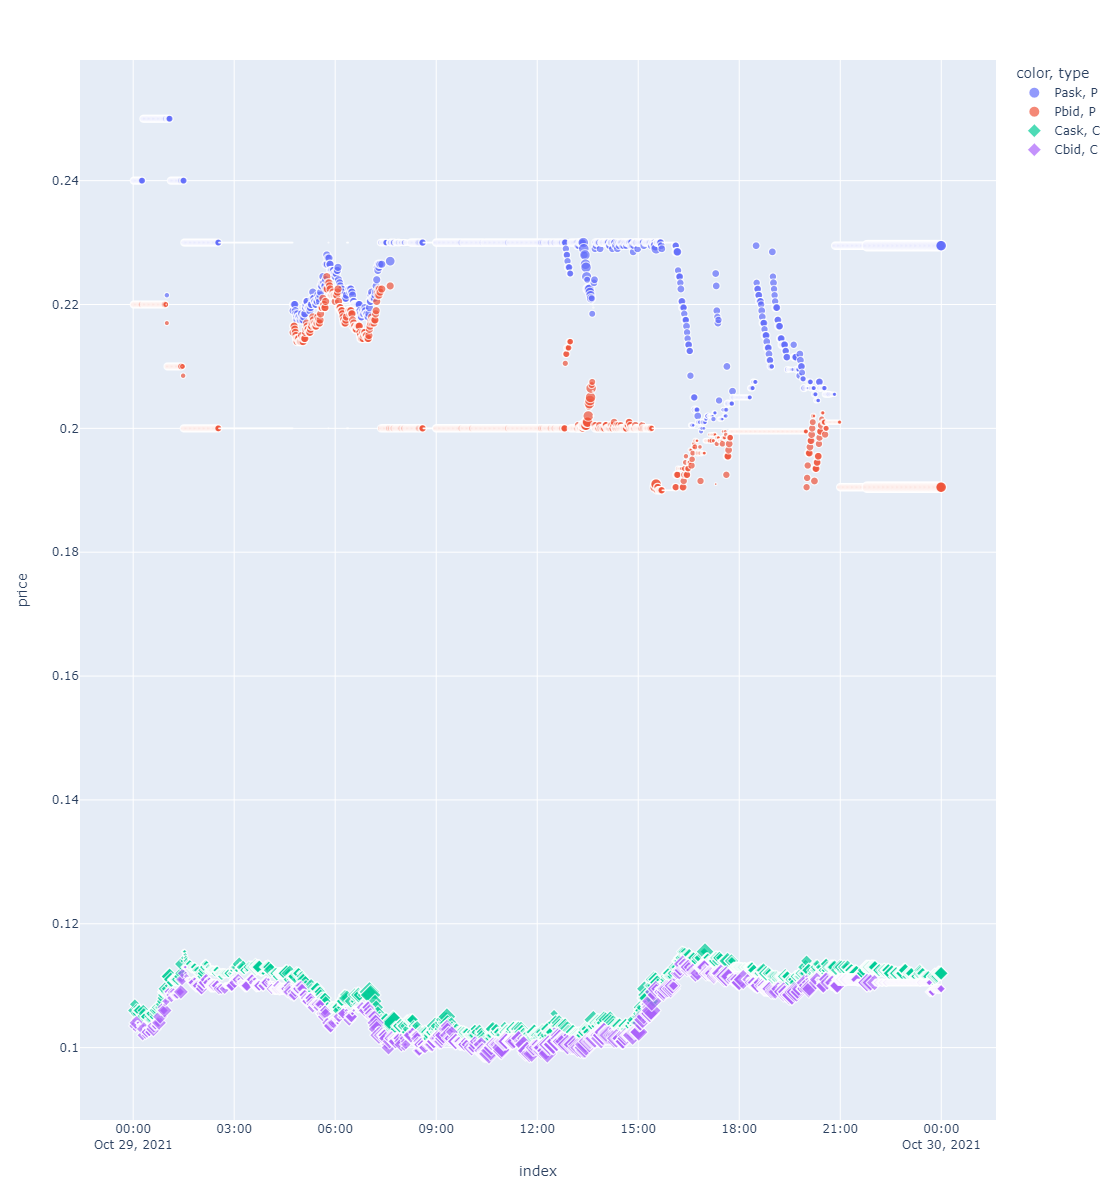

In [87]:
subfig = make_subplots(specs=[[{"secondary_y": True}]])
strike = 70000
fig1 = px.scatter(df_combined_ext_transformed, x="index", y="price", size="amount",  hover_data=['price','amount','type','side','iv'],symbol='type', color=df_combined_ext_transformed.color, title='',width=1500, height=1200)
fig1.show()
#fig1.update_yaxes(range=[60000, 80000])

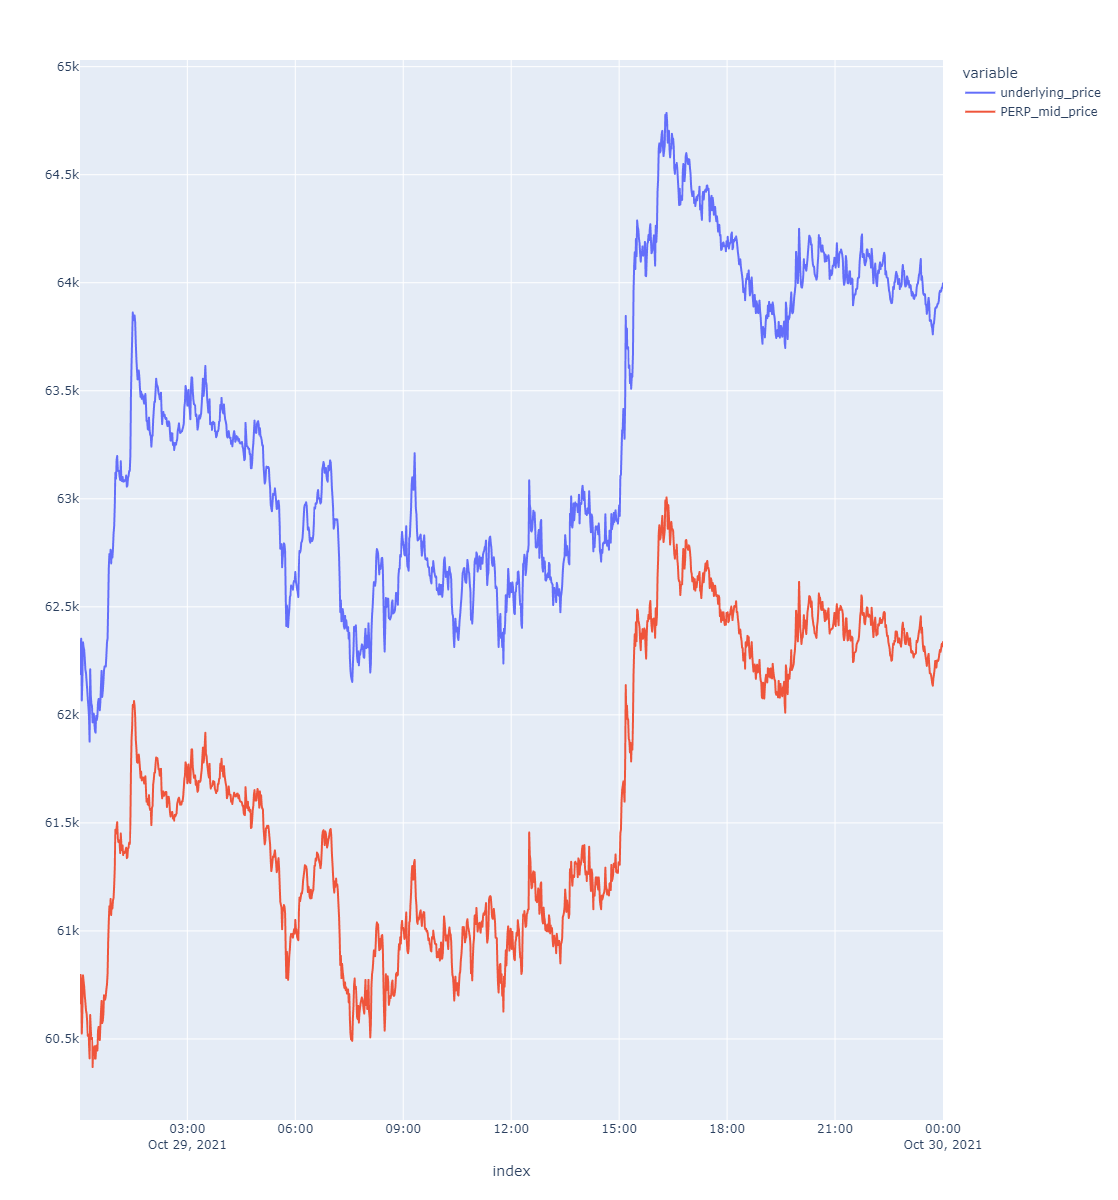

In [88]:
fig2 = px.line(df_underlying, x="index", y=['underlying_price','PERP_mid_price'], width=1500, height=1200, )
fig2.update_traces(yaxis="y2")
#fig2.update_yaxes(range=[60000, 80000])

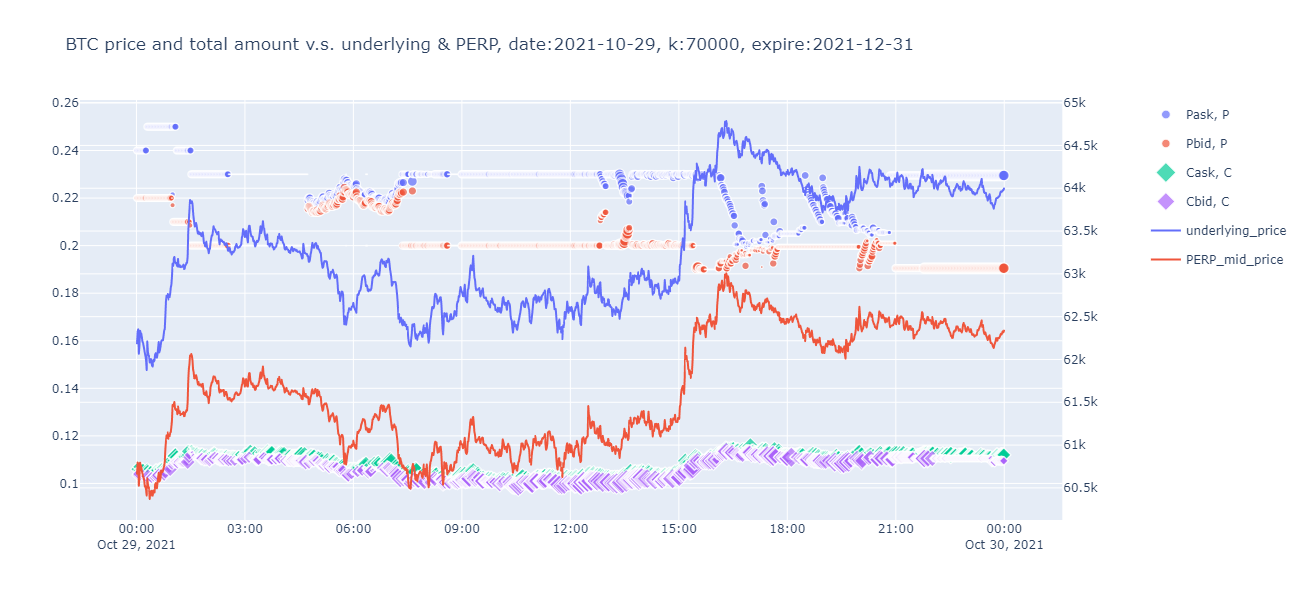

In [89]:
subfig.add_traces(fig1.data + fig2.data)
subfig.update_layout(
    autosize=False,
    width=1500,
    height=600,
    title='{} price and total amount v.s. underlying & PERP, date:{}, k:{}, expire:{} '.format(coin, date, strike, maturity_date),)

In [ ]:
df_combined_ext_transformed

In [ ]:
subfig.write_html(os.path.join(LOCAL_FIGURE_DIR, 'option_book', date.strftime('%Y%m'), "{}_option_{}_{}_{}.html".format(coin, date.strftime('%Y%m%d'), maturity_date.strftime('%Y%m%d'), strike)))